In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'


Inpainting lesions in a mammogram is challenging specially due to the size of the mammograms. <br>
Stable diffusion pipelines usually require the images to be resized to a smaller size, which is not ideal for mammograms. <br>

    Idea: What if we generate only in a small region of the mammogram and then paste it back to the original image? <br>
        Pros:
        - Keep the original size of the mammogram
        - High quality lesions generated
        Cons:
        - The generated region may not be coherent with the rest of the image: SD-inpaiting has proven to slightly changethe rest of the image, but it may not be very important. <br>
        - How do you select the region to inpaint? <br>

# Region to inpaint
Several options are available, all considering a 512x512 region to inpaint. <br>
1. Centered-mass region: the lesion is always in the center and we just grow the region to 512x512. <br>
    - May fail if the lesion is in the border of the mammogram (not enough space to grow the region)
2. Random-mass-position region: the mass may be in whichever part of the inpainting regionn. <br>
    - It also has to consider the case when the growing region is out of the mammogram. <br>

    We will go for the random option, as it seems more general. <br>

In [50]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We see that some image shave a greater size than the limit 512x512.<br>
- Some cases are bbox of too large regions or not clear lesions.
- This should not represent a problem, as the big lesions are relatively easy to detect.
- We keep only the small lesions for the inpainting. <br>

In [49]:
# show image and bbox
def image_bbox(bbox_df, lesion_num, info_bbox):
    """show image and bbox

    Args:
        bbox_df (pd.DataFrame): dataframe with the bounding boxes
        lesion_num (int): index of the lesion
        info_bbox (tuple): (x, y, w, h) of the bounding box
    """
    # show case
    im = cv.imread(str(repo_path / 'data/CDD-CESM/images/substracted' / (bbox_df['image_name'][lesion_num] + '.jpg')))
    x, y, w, h = info_bbox
    plt.figure()
    cv.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(im)
    plt.title(f'Width: {w}, Height: {h}')

In [48]:
# check the size of the lesions in general
bbox_csv_path = repo_path  /'data/CDD-CESM/masks/bbox_CESM.csv'
bbox_df = pd.read_csv(bbox_csv_path)

small_count = 0
bigger_count = 0
show_limit = 20
for lesion_num in range(len(bbox_df)):
    info_bbox = eval(bbox_df['bbox'][lesion_num])
    w, h = info_bbox[2], info_bbox[3]
    
    if w < 512 and h < 512:
        small_count += 1
        
    elif w > 512 or h > 512:
        bigger_count += 1
        # if bigger_count < show_limit:
            # image_bbox(bbox_df, lesion_num, info_bbox)

print(f'Small lesions: {small_count}, Bigger lesions: {bigger_count}')

Small lesions: 475, Bigger lesions: 119


We keep only the lesion regions smaller than 512 for the inpainting. <br>

In [61]:
# check the size of the lesions in general
bbox_csv_path = repo_path  /'data/CDD-CESM/masks/bbox_CESM.csv'
bbox_df = pd.read_csv(bbox_csv_path)

large_lesion_ids = []
for row_num in range(len(bbox_df)):
    row = bbox_df.iloc[row_num]
    _, _, w, h = eval(row['bbox'])
    if w > 512 or h > 512:
        large_lesion_ids.append(row_num)
# remove this rows
bbox_small_df = bbox_df.drop(large_lesion_ids)
bbox_small_df['patient_id'].unique().shape
bbox_small_df.to_csv(repo_path / 'data/CDD-CESM/masks/bbox_small_masses.csv', index=False)

# Expand bbox to be 512x512

From the remaining lesions, we expand the bbox to be 512x512. <br>

In [66]:
bbox_small_df.head()

,patient_id,image_name,region_id,bbox
0,2,P2_R_CM_CC,0,"(536, 2083, 355, 307)"
1,2,P2_R_CM_CC,1,"(633, 1620, 411, 283)"
2,2,P2_R_CM_CC,2,"(347, 1233, 307, 211)"
3,2,P2_R_CM_CC,3,"(629, 750, 129, 129)"
4,2,P2_R_CM_CC,4,"(738, 1161, 153, 153)"


Current width: 307, Current height: 211
Expand width: 205, Expand height: 301
New x: 281, New y: 997, New width: 512, New height: 512


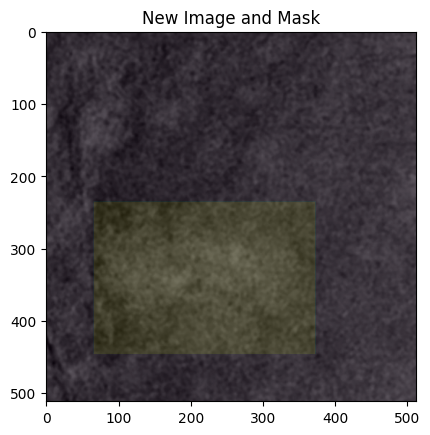

In [247]:
# information
bbox_small_df = pd.read_csv(repo_path / 'data/CDD-CESM/masks/bbox_small_masses.csv')
im_dir = repo_path / 'data/CDD-CESM/images/substracted'


# loop on rows
ex_row = bbox_small_df.iloc[2]
# image
im_path = im_dir /  (ex_row['image_name'] + '.jpg')
im = cv.imread(str(im_path))
im_x_max, im_y_max = im.shape[1], im.shape[0]
# read mask image
mask_path = repo_path / 'data/CDD-CESM/masks/substracted' / f"{ex_row['image_name']}_reg{ex_row['region_id']}.png"
mask = cv.imread(str(mask_path), cv.IMREAD_GRAYSCALE)

#bbox math
current_x, current_y, current_w, current_h = eval(ex_row['bbox'])
print(f'Current width: {current_w}, Current height: {current_h}')
# expanding requirement
expand_w = 512 - current_w
expand_h = 512 - current_h
print(f'Expand width: {expand_w}, Expand height: {expand_h}')
# expand the bbox on both sides, unevenly following a random ratio
left_expand = np.random.randint(0, expand_w)
right_expand = expand_w - left_expand
top_expand = np.random.randint(0, expand_h)
bottom_expand = expand_h - top_expand

# create new bbox
new_x = current_x - left_expand
new_y = current_y - top_expand
new_w = current_w + left_expand + right_expand
new_h = current_h + top_expand + bottom_expand
# check if the new bbox is out of the image
if new_x < 0:
    new_x = 0
if new_y < 0:
    new_y = 0
if new_x + new_w > im_x_max:
    new_x = im_x_max - new_w
if new_y + new_h > im_y_max:
    new_y = im_y_max - new_h
print(f'New x: {new_x}, New y: {new_y}, New width: {new_w}, New height: {new_h}')

# save new image and mask coordinates
new_im = im[new_y:new_y+new_h, new_x:new_x+new_w]
new_mask = mask[new_y:new_y+new_h, new_x:new_x+new_w]
# convert the original shape free binary mask to a bbox square mask
x, y, w, h = cv.boundingRect(new_mask)
new_mask = np.zeros_like(new_mask)
new_mask[y:y+h, x:x+w] = 255


# plot them
plt.figure()
plt.imshow(new_im)
plt.imshow(new_mask, alpha=0.1)
plt.title('New Image and Mask')
plt.show()

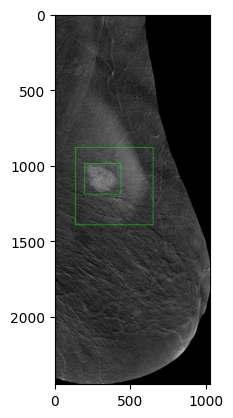

In [195]:
# for checking bbox
im_path = repo_path / 'data/CDD-CESM/images/substracted' / (ex_row['image_name'] + '.jpg')
im = cv.imread(str(im_path))
x, y, w, h = eval(ex_row['bbox'])
plt.figure()
cv.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv.rectangle(im, (new_x, new_y), (new_x+new_w, new_y+new_h), (0, 255, 0), 2)
plt.imshow(im)

In [199]:
im.shape

(2446, 1030, 3)